In [1]:
'''
This is a file for final combine strategy and backtest result plot.
'''
import numpy as np
import pandas
import vectorbt as vbt
data = pandas.read_csv('BTC-USD1h.csv')
data = data.set_index('Date')
RSI = vbt.IndicatorFactory.from_talib("RSI")
STOCH = vbt.IndicatorFactory.from_talib("STOCH")

C:\Users\User\Desktop\backtestsystem\.venv\Lib\site-packages\telegram\utils\request.py:49: UserWarning: python-telegram-bot is using upstream urllib3. This is allowed but not supported by python-telegram-bot maintainers.
  warnings.warn(


In [3]:
train_end = '2022-08-30'
BENCHMARK='benchmark'

In [4]:
'''
implement long top five parameter strategy

'''
import numpy as np
import vectorbt as vbt
from numba import njit
@njit
def cross_above(a, b):
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def cross_below(a, b):
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit
def produce_signal(rsi_values, slowk_values, slowd_values):
    cross = cross_above(slowk_values, slowd_values)
    trend = np.zeros(len(rsi_values), dtype=np.int32)
    for i in range(1, len(rsi_values)):
        if rsi_values[i] > 60 and cross[i-1] :
            trend[i] = 1
        elif rsi_values[i] < 40:
            trend[i] = -1

    return trend



def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    # Calculate RSI
    rsi = RSI.run(close, rsi_window).real
    # Calculate Stochastic Oscillator
    stoch = STOCH.run(
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    # Convert to numpy arrays
    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()


    # Ensure no NaNs

    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=[34,38,32,80,82],
    fastk_period=[20,25,24,5,6],
    slowk_period=3,
    slowd_period=3,
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h',direction='longonly',fees=0.05/100,sl_stop=0.05)
long_returns = pf.returns()


In [5]:
'''
implement short top five parameter strategy
'''
import numpy as np
import pandas
import pandas as pd
import vectorbt as vbt
from numba import njit

@njit
def cross_above(a, b):
    return (a[:-1] <= b[:-1]) & (a[1:] > b[1:])

@njit
def cross_below(a, b):
    return (a[:-1] >= b[:-1]) & (a[1:] < b[1:])

@njit
def produce_signal(rsi_values, slowk_values, slowd_values):
    cross = cross_below(slowk_values,slowd_values)
    trend = np.zeros(len(rsi_values), dtype=np.int32)
    for i in range(1, len(rsi_values)):
        if rsi_values[i] < 30 and cross[i-1] :
            trend[i] = 1
        elif rsi_values[i] > 50:
            trend[i] = -1

    return trend



def custom_indicator(close, high, low, rsi_window=32, fastk_period=9, slowk_period=3,slowd_period=3):
    rsi = RSI.run(close, rsi_window).real     # Calculate RSI
    stoch = STOCH.run(    # Calculate Stochastic Oscillator
        high,
        low,
        close,
        fastk_period=fastk_period,
        slowk_period=slowk_period,
        slowk_matype=0,
        slowd_period=slowd_period,
        slowd_matype=0
    )

    # Convert to numpy arrays
    rsi_values = rsi.to_numpy()
    slowk_values = stoch.slowk.to_numpy()
    slowd_values = stoch.slowd.to_numpy()


    # Ensure no NaNs

    rsi_values = np.nan_to_num(rsi_values)
    slowk_values = np.nan_to_num(slowk_values)
    slowd_values = np.nan_to_num(slowd_values)

    return produce_signal(rsi_values,slowk_values,slowd_values)

# Define the custom indicator using IndicatorFactory
ind = vbt.IndicatorFactory(
    class_name="Combination",
    short_name="comb",
    input_names=['close', 'high', 'low'],
    param_names=['rsi_window', 'fastk_period', 'slowk_period', 'slowd_period'],
    output_names=["value"]
).from_apply_func(
    custom_indicator,
    rsi_window=32,
    fastk_period=9,
    slowk_period=3,
    slowd_period=3)

# Run the indicator
res = ind.run(
    data['close'],
    data['high'],
    data['low'],
    rsi_window=[12,34,34,12,12],
    fastk_period=[6,5,6,1,12],
    slowk_period=3,
    slowd_period=3,
)

# Generate entries and exits signals
entries = res.value == 1
exits = res.value == -1

# Create a portfolio from the signals
pf = vbt.Portfolio.from_signals(data['close'], entries, exits,freq='1h',direction='shortonly',fees=0.05/100,sl_stop=0.05)
tmp= pf.returns()
short_returns=pd.DataFrame(tmp.values,index=tmp.index,columns=tmp.columns)


In [6]:
import matplotlib.pyplot as plt
def plot_cumsum(demo_ret):
    fig, ax = plt.subplots(figsize=(24,8))
    ax.axvline(x= pd.to_datetime(train_end) , ymin=0, ymax=4.5)
    for col in demo_ret.columns:
        demo_ret[col].plot(ax=ax, label=col)
    plt.legend()
    plt.title('Cumsum Return')
    plt.show()
    
from scipy.optimize import minimize

UPPER_WEIGHT = 0.5

def max_sharpe(stras_return):
    def efficient_frontier(expected_returns, cov_matrix, risk_free_rate):
        num_assets = len(expected_returns)
        initial_weights = np.ones(num_assets) / num_assets  # Initial equal weights

        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})  # Sum of weights = 1

        bounds = tuple((0.05, UPPER_WEIGHT) for _ in range(num_assets))  # Each weight is between 0 and 1
        result = minimize(objective, initial_weights, args=(expected_returns, cov_matrix, risk_free_rate),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        efficient_weights = result.x
        return efficient_weights

    def objective(weights, expected_returns, cov_matrix, risk_free_rate):
        portfolio_return = np.sum(expected_returns * weights)
        portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_std
        return -sharpe_ratio  # We minimize the negative of the Sharpe ratio to maximize it

    risk_free_rate = 0
    cov_matrix = stras_return.cov().values
    sharp_weight = efficient_frontier(stras_return.mean().values, cov_matrix, risk_free_rate)
    sharp_weight = pd.DataFrame(sharp_weight, index = stras_return.columns, columns = ['sharpe_weight']).T
    return sharp_weight



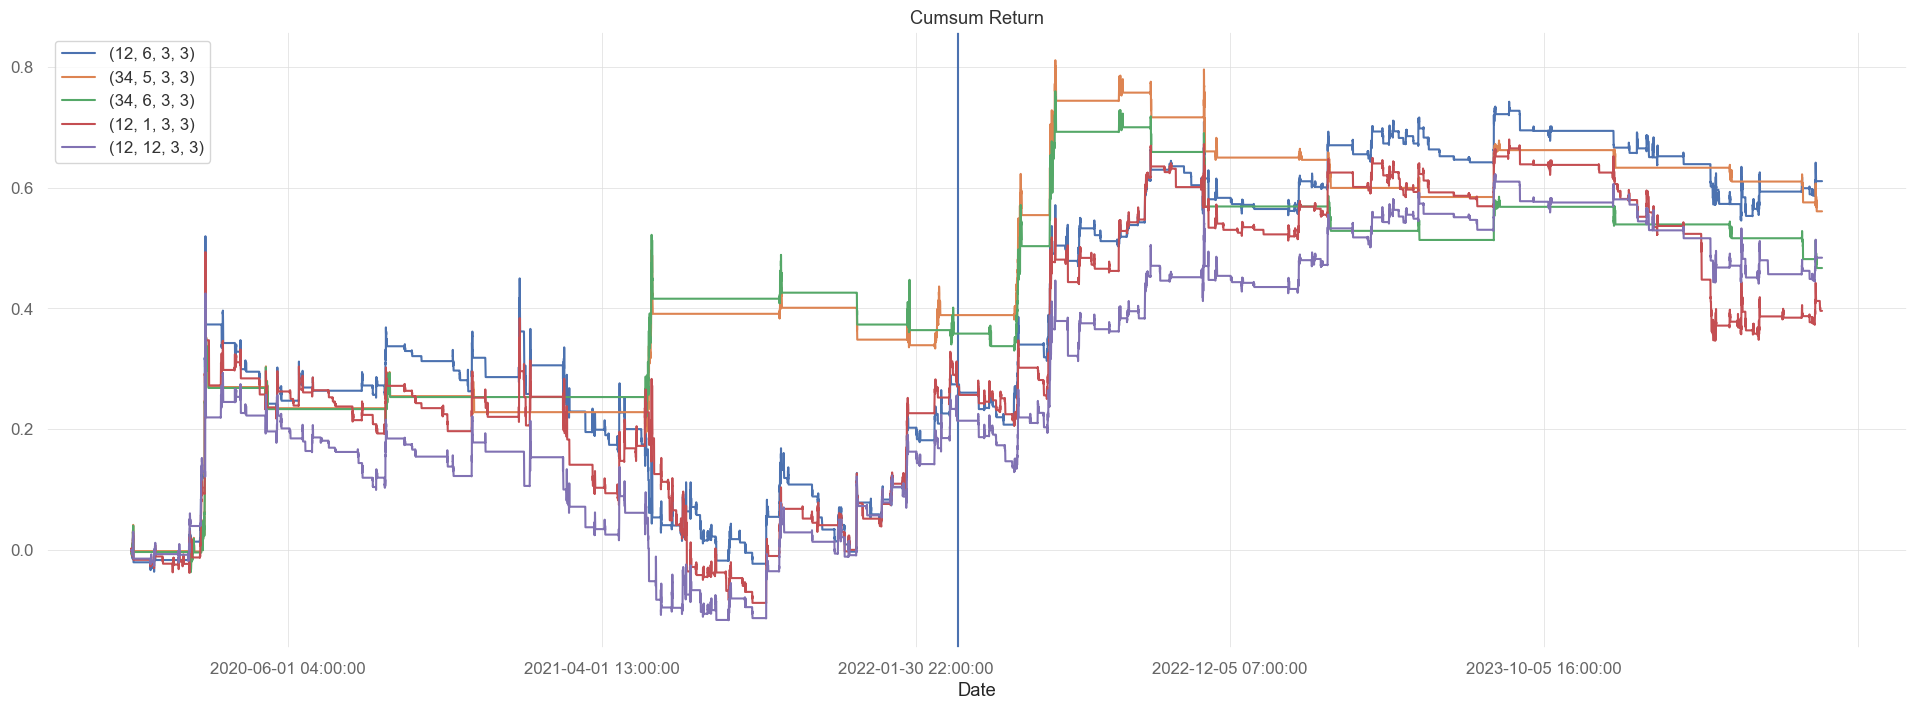

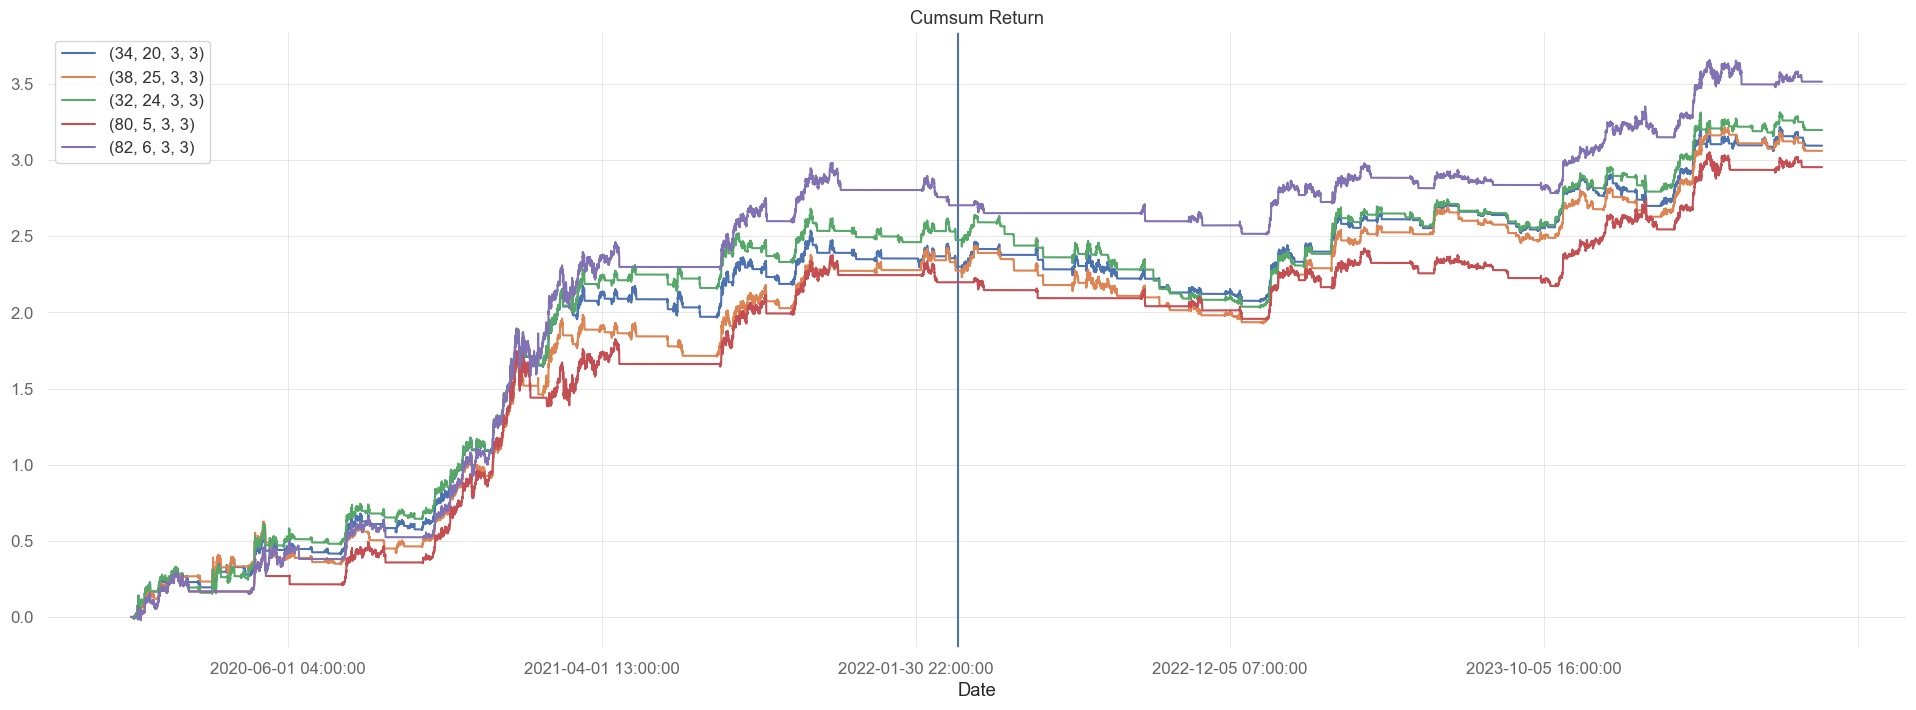

In [15]:
plot_cumsum(short_returns.cumsum())
plot_cumsum(long_returns.cumsum())

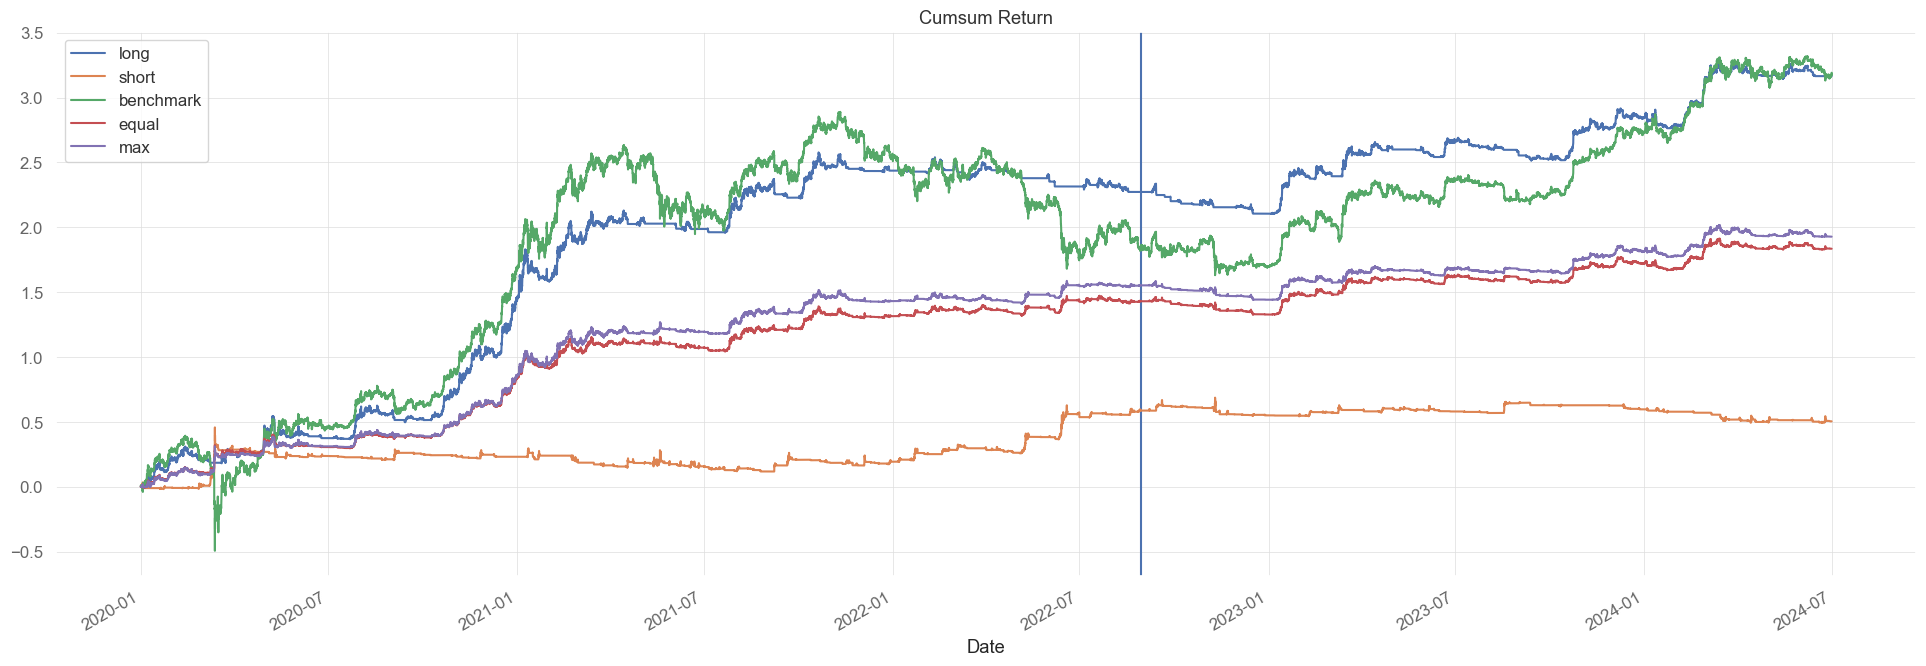

In [7]:
demo_df=pd.DataFrame()
demo_df['long']=long_returns.mean(axis=1)
demo_df['short']=short_returns.mean(axis=1)
demo_df[BENCHMARK]=data['close'].pct_change()
demo_df['equal']=demo_df['long']*0.5+demo_df['short']*0.5
ls_df=pd.concat([long_returns, short_returns], axis = 1)
max_w = max_sharpe(ls_df.loc[:train_end])
demo_df['max'] =  (ls_df*max_w.values).sum(axis = 1)
demo_df.index = pd.to_datetime(demo_df.index)
plot_cumsum(demo_df.cumsum())

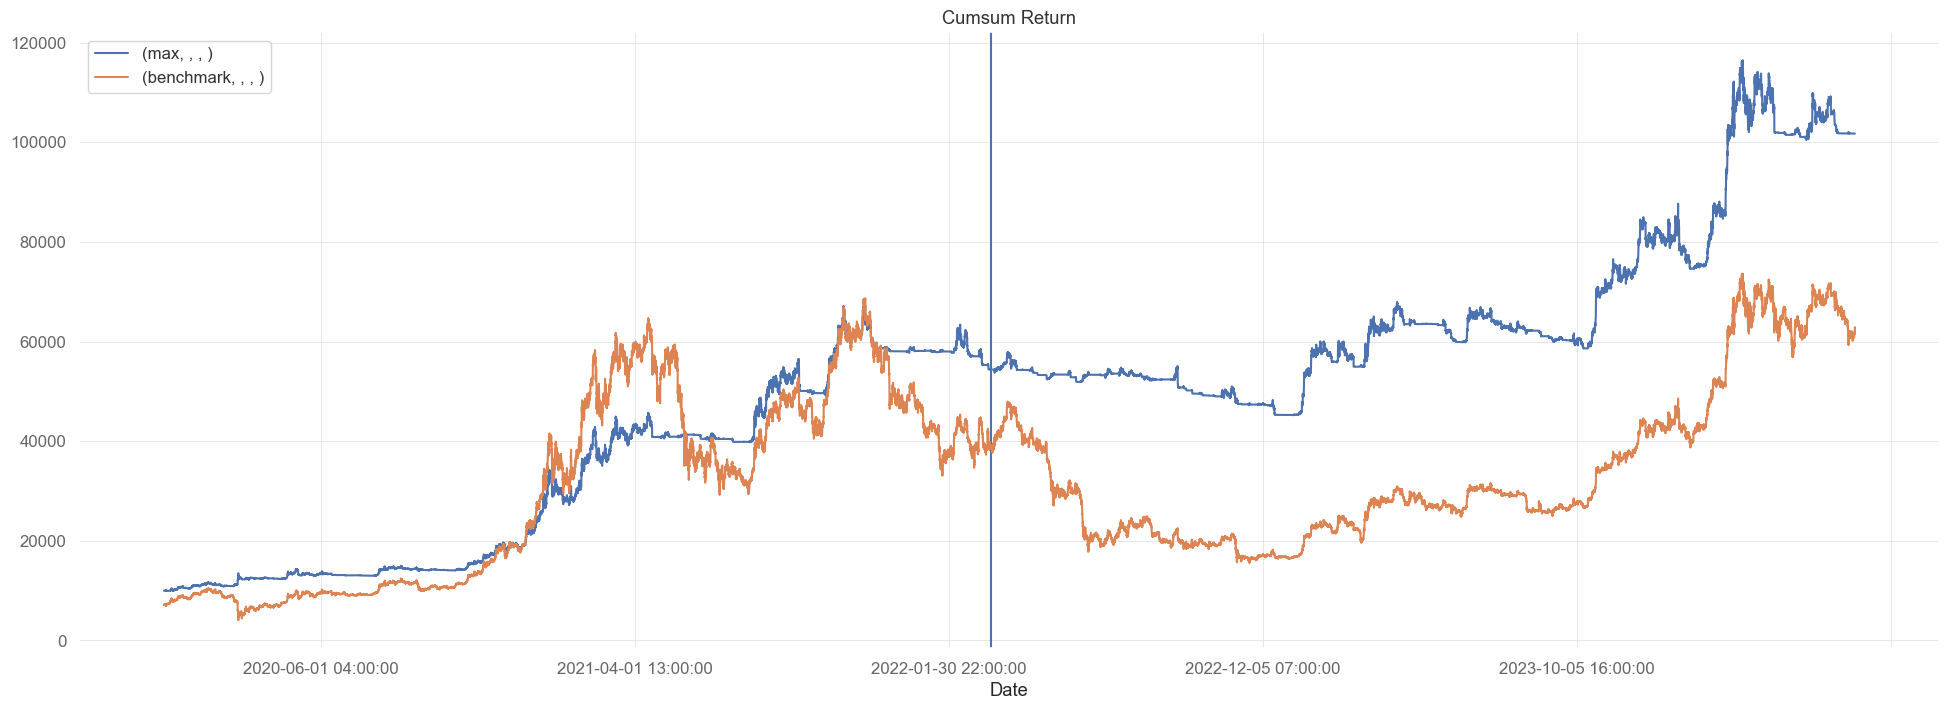

In [8]:
show_df=(ls_df+1).cumprod()*max_w.values*10000
show_df['max'] =show_df.sum(axis=1)
show_df['benchmark'] = data['close']
plot_cumsum(show_df.iloc[:,-2:])

In [9]:
def two_profit(df, title = 'title'):
    col1 = df.columns[0]
    col2 = df.columns[1]


    def calculate_drawdown(series):
        high_water_mark = series.cummax()
        drawdown = series - high_water_mark
        return drawdown

    df['drawdown'] = calculate_drawdown(df[col1])
    high_points = df[col1].cummax()
    new_high = df[df[col1] == high_points][col1]
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), dpi=200, sharex=True)
    color_1 = '#1f77b4'
    color_2 = '#ff7f0e'
    color_drawdown = '#d62728'
    color_high = '#00FF00'


    ax1.plot(df.index, df[col1], label=col1, color=color_1)
    ax1.plot(df.index, df[col2], label=col2, color=color_2)
    ax1.set_title(title, fontsize=16, fontweight='bold')
    ax1.axvline(x= pd.to_datetime(train_end) , ymin=0, ymax=4.5)
    # ax1.set_ylabel('Value', fontsize=14)
    ax1.legend(loc='upper left', fontsize='small')


    ax2.plot(df.index, df[col1], label=col1, color=color_1)
    ax2.fill_between(df.index, df['drawdown'], 0, color=color_drawdown, alpha=0.5, label='Drawdown')
    ax2.scatter(new_high.index, new_high, color=color_high, label='High', zorder=5, alpha = 0.7)
    ax2.set_title('Drawdown', fontsize=16, fontweight='bold')
    ax2.set_xlabel('Date', fontsize=14)
    ax2.axvline(x= pd.to_datetime(train_end) , ymin=0, ymax=4.5)
    # ax2.set_ylabel('Value', fontsize=14)
    ax2.legend(loc='upper left', fontsize='small')


    for ax in [ax1, ax2]:
        ax.grid(True)
        # ax.set_facecolor('whitesmoke')
        ax.tick_params(axis='x', labelsize=12, rotation=45)
        ax.tick_params(axis='y', labelsize=12)
    plt.tight_layout()
    plt.show()
    df = df.drop(columns = 'drawdown')


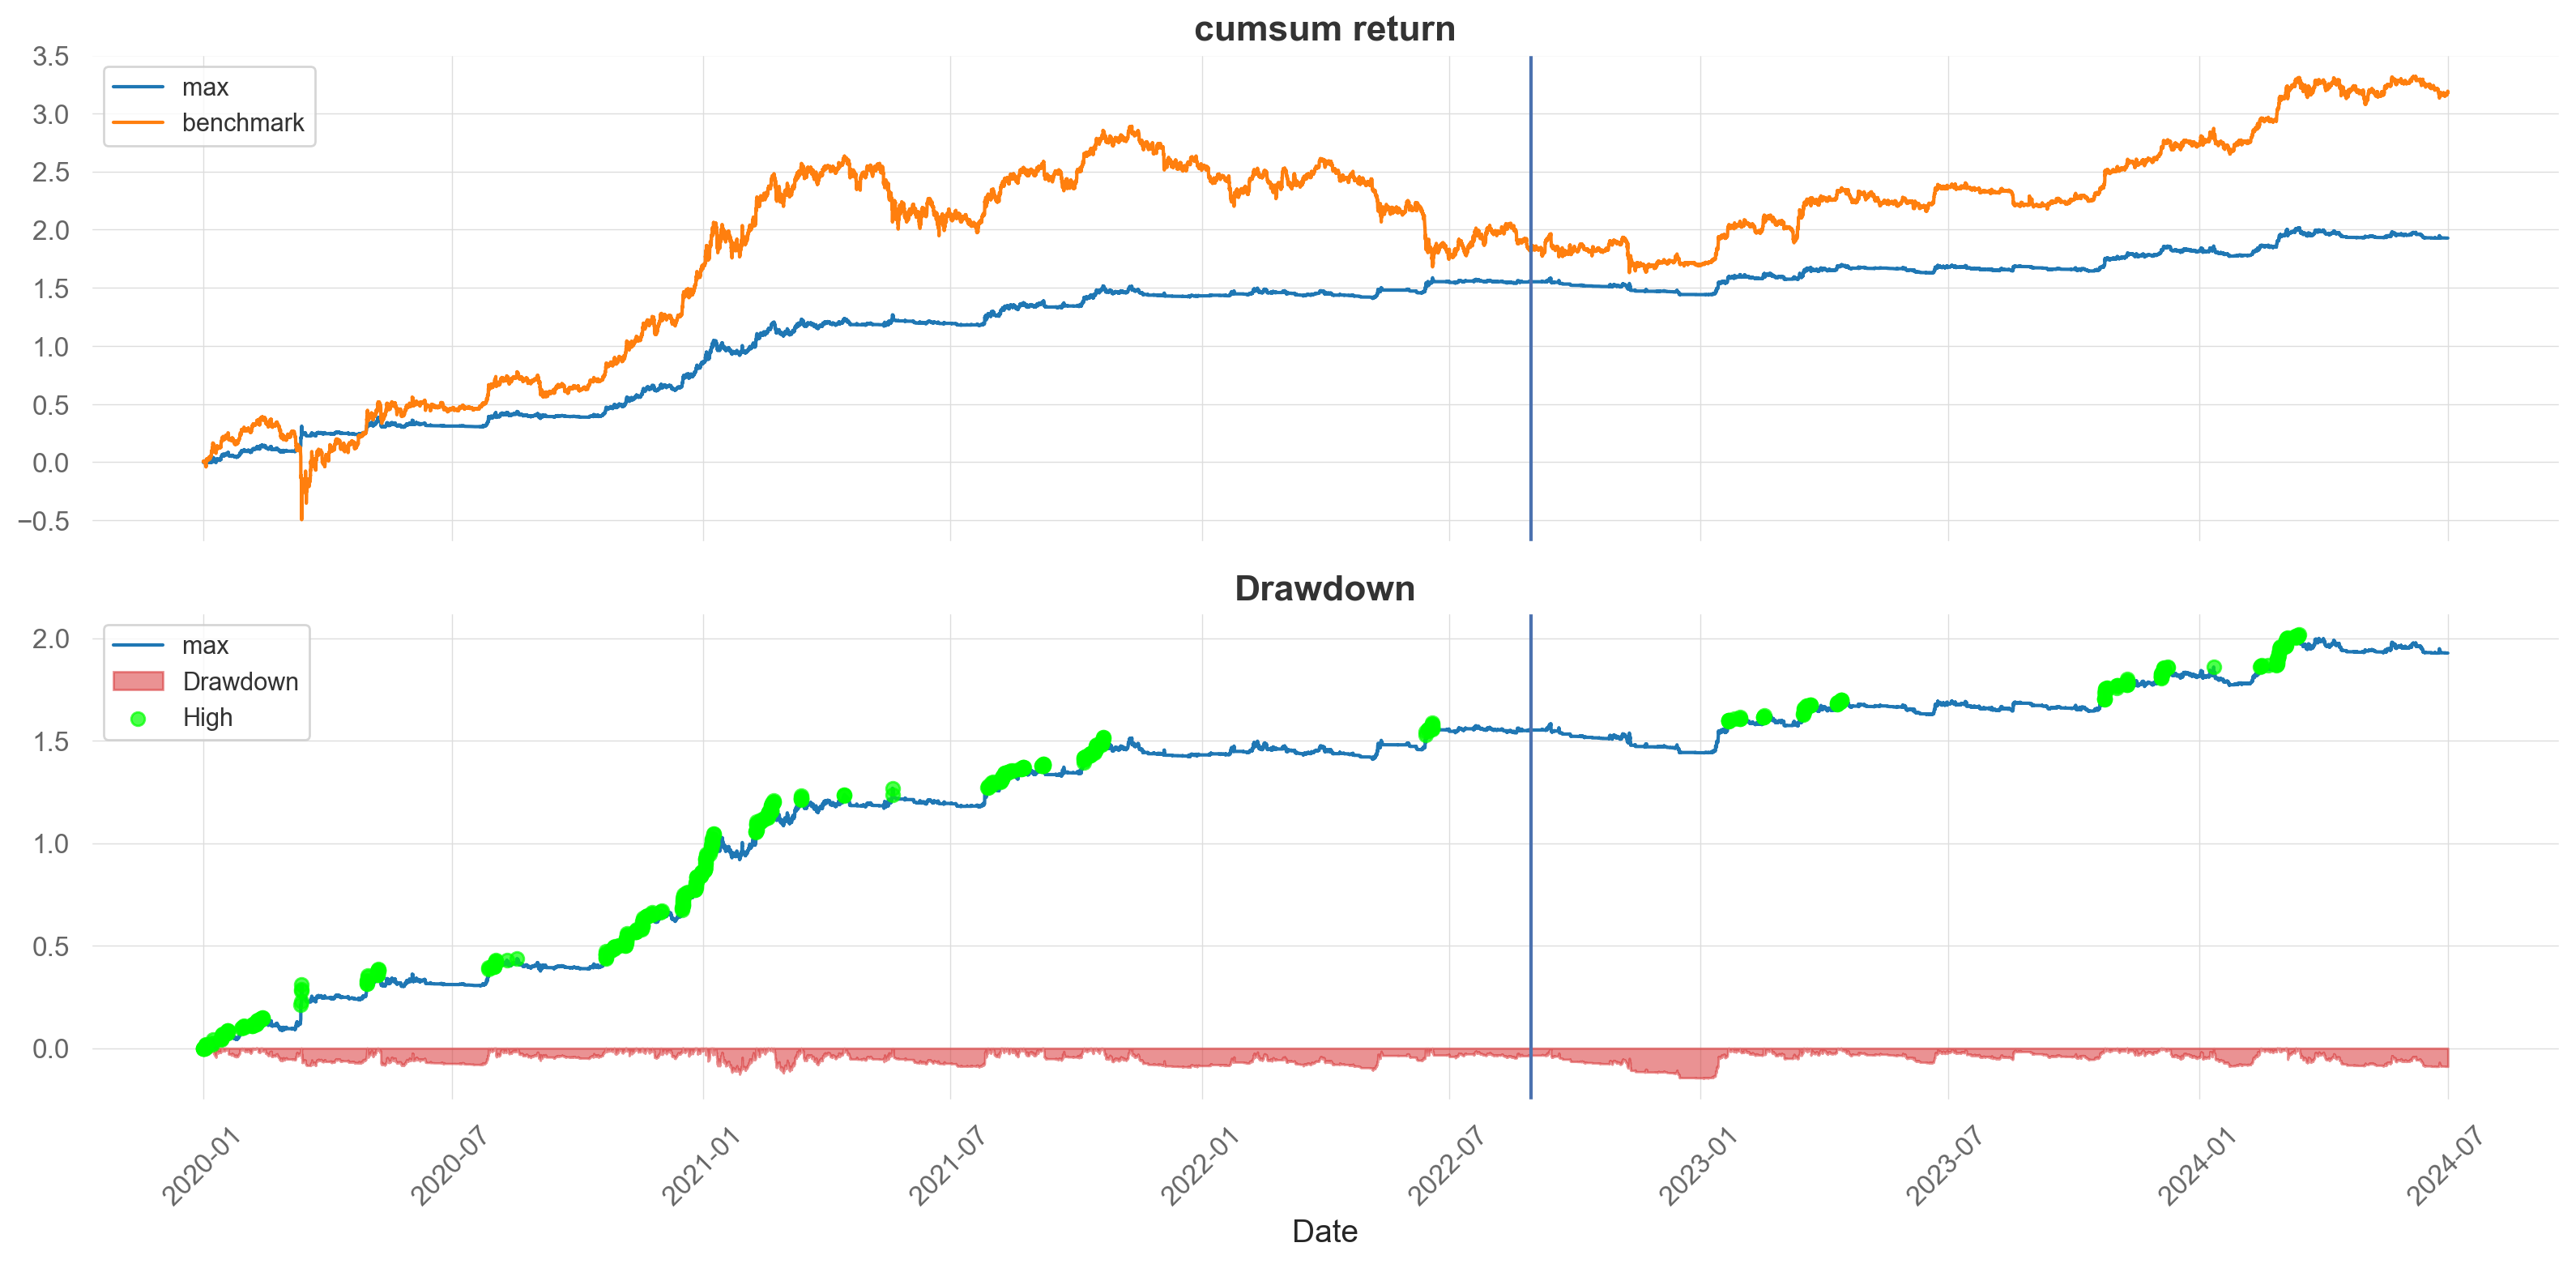

In [10]:
two_profit(demo_df[['max',BENCHMARK]].cumsum(), title = 'cumsum return')

In [11]:
import quantstats as qs
ANNUAL_MULTI = 365*24

def eveluate(sp_strats, benchmark, name):
    df_metrics = pd.DataFrame()
    for col in sp_strats.columns:
        if col == benchmark:
            df_metrics[col] = qs.reports.metrics(sp_strats[benchmark], mode='full', periods_per_year = ANNUAL_MULTI, display=False)
        else:
            df_metrics[col]= qs.reports.metrics(sp_strats[col], mode='full',
                                                display=False,
                                                periods_per_year = ANNUAL_MULTI,
                                                benchmark=sp_strats[benchmark])['Strategy']
    df_metrics.columns = [ i + "%s"%name for i in df_metrics.columns]
    return df_metrics


In [12]:
df_metrics_in = eveluate(demo_df.loc[:train_end], benchmark = BENCHMARK, name = '_in')
df_metrics_out = eveluate(demo_df.loc[train_end:], benchmark = BENCHMARK, name = '_out')
df_metrics_all = eveluate(demo_df, benchmark = BENCHMARK, name = '_all')
df_metrics = pd.concat([df_metrics_in, df_metrics_out, df_metrics_all], axis=1)

C:\Users\User\Desktop\backtestsystem\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\User\Desktop\backtestsystem\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\User\Desktop\backtestsystem\.venv\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.prod with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not

In [13]:
df_metrics.head(60)

,long_in,short_in,benchmark_in,equal_in,max_in,long_out,short_out,benchmark_out,equal_out,max_out,long_all,short_all,benchmark_all,equal_all,max_all
Start Period,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2020-01-01,2020-01-01,2020-01-01,2020-01-01,2020-01-01
End Period,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2022-08-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30,2024-06-30
Risk-Free Rate,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Time in Market,0.63,0.19,1.0,0.76,0.76,0.68,0.14,1.0,0.77,0.77,0.66,0.17,1.0,0.76,0.76
Cumulative Return,6.73,0.66,1.76,2.89,3.38,1.25,-0.09,2.1,0.46,0.42,16.35,0.51,7.75,4.7,5.22
CAGR﹪,0.7,0.14,0.3,0.42,0.47,0.36,-0.04,0.53,0.15,0.14,0.55,0.06,0.4,0.31,0.32
Sharpe,2.07,0.9,0.88,2.33,2.47,1.61,-0.35,1.54,1.38,1.26,1.89,0.54,1.06,2.0,2.04
Prob. Sharpe Ratio,1.0,0.94,0.92,1.0,1.0,0.99,0.32,0.98,0.97,0.96,1.0,0.88,0.99,1.0,1.0
Smart Sharpe,2.06,0.86,0.87,2.31,2.44,1.58,-0.35,1.51,1.36,1.23,1.88,0.53,1.04,1.98,2.02
Sortino,2.96,1.48,1.23,3.47,3.68,2.33,-0.51,2.2,2.0,1.81,2.72,0.87,1.48,2.95,3.02
